---
title: Penguins Blog
author: Dean Smith
date: '2023-4-18'
image: "image.jpg"
description: "In this blog I build a model to classify different penguins"
format: html
---

# Penguins

In this blog, I will work with a dataset to classify penguins into 3 species. My dataset contains 17 potential features but in this blog my challenge is to use only 3 of these features to classify penguins at 100% accuracy. The purpose of this blog is to show how one might eliminate irrelevant features to save computation time and still give effective results.

In the code cell below, I import my pandas dependency and import my training dataset from a remote github repo.

In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)



To see the first 5 rows of my training dataset run the code cell below

In [2]:
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,27,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N46A1,Yes,11/29/07,44.5,14.3,216.0,4100.0,NaN,7.96621,-25.69327,NaN
1,PAL0708,22,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N41A2,Yes,11/27/07,45.1,14.5,215.0,5000.0,FEMALE,7.63220,-25.46569,NaN
2,PAL0910,124,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N67A2,Yes,11/16/09,41.4,18.5,202.0,3875.0,MALE,9.59462,-25.42621,NaN
3,PAL0910,146,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,"Adult, 1 Egg Stage",N82A2,Yes,11/16/09,39.0,18.7,185.0,3650.0,MALE,9.22033,-26.03442,NaN
4,PAL0708,24,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N85A2,No,11/28/07,50.6,19.4,193.0,3800.0,MALE,9.28153,-24.97134,NaN


Here, I import my sklearn.preprocessing pacakge and prepare my data. This process includes hot encoding and dropping unnessecary features such as comments and individual ID.

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0


In the code cell below, I import a combinations package to help me find all combinations of features where one is qualitative data and the other two are quantitative data. The purpose of this is to later test which combination of features yields the best performance in the classification model.

In [4]:
from itertools import combinations

all_qual_cols = ["Clutch Completion", "Sex", "Island", "Stage"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']

col_combos = []

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    col_combos.append(cols)
  


Here, I determine the best features and the training score of these features.

In [5]:
from sklearn.linear_model import LogisticRegression
import warnings


warnings.filterwarnings("ignore") # I was getting a lot of warnings

best_score = 0.0
best_cols = ["N/A"]

for col in col_combos:
    LR = LogisticRegression()
    LR.fit(X_train[col], y_train)
    score = LR.score(X_train[col], y_train)

    if score > best_score:
        best_score = score
        best_cols = col

print(best_score)
print(best_cols)


1.0
['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)']


Now, I get my model with the best features and train it for the testing phase.

In [6]:
best_cols = best_cols[(len(best_cols) - 2):] + best_cols[:(len(best_cols) - 2)]

LR = LogisticRegression()
LR.fit(X_train[best_cols], y_train)
score = LR.score(X_train[best_cols], y_train)

print(score)

1.0


In the code cell below, I test my model against an imported testing dataset and print the testing score.

In [7]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)


X_test, y_test = prepare_data(test)
LR.score(X_test[best_cols], y_test)

1.0

In the next two code cells, I prep the training data to only include the best features in order to show them visually. 

In [8]:
from matplotlib import pyplot as plt
import numpy as np

X_train[best_cols]

,Culmen Length (mm),Culmen Depth (mm),Island_Biscoe,Island_Dream,Island_Torgersen
1,45.1,14.5,1,0,0
2,41.4,18.5,0,0,1
3,39.0,18.7,0,1,0
4,50.6,19.4,0,1,0
5,33.1,16.1,0,1,0
...,...,...,...,...,...
269,41.1,17.5,0,1,0
270,45.4,14.6,1,0,0
271,36.2,17.2,0,0,1
272,50.0,15.9,1,0,0


In [9]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Finally, we are able to visualize the performance of this model.

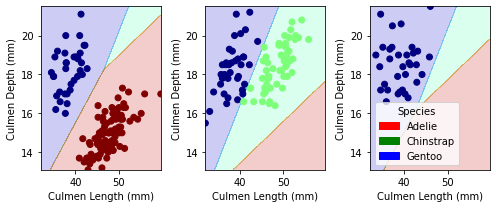

In [10]:
plot_regions(LR, X_train[best_cols], y_train)

In our findings, we determined that Island, Culmen Length, and Culmen Depth were the best combination of features to classify penguins into the Adelie, Chinstrap, and Gentoo species. We were able to obtain a 100% training accuracy along with a 100% testing accuracy. Lastly, we represented the data visually and can see that our model effectively classifies penguins into these species.